## 1. Load Image

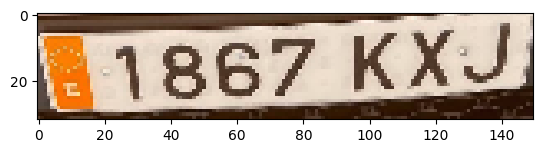

In [32]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Cargar imagen desde path
image = cv2.imread('tmp_cropped/tmp_cropped_18.jpg')

# Resize mantain aspect ratio
ar1 = image.shape[1] / image.shape[0]
new_width = 150
new_height = int(new_width / ar1)
image = cv2.resize(image, (new_width, new_height))

# Mostar imagen
plt.imshow(image)


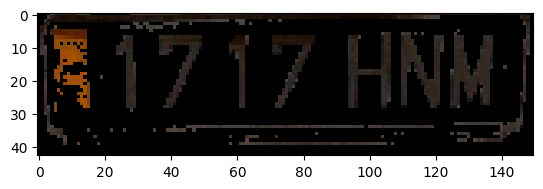

In [30]:
imagecpy = image.copy()
# Convertir la imagen a escala de grises (opcional)
gray_image = cv2.cvtColor(imagecpy, cv2.COLOR_BGR2GRAY)

# Crear una máscara de los píxeles superiores a 230
# La máscara tendrá valores 255 donde la condición es verdadera y 0 donde es falsa
mask = gray_image < 70

# Convertir la máscara a tipo uint8
mask = mask.astype(np.uint8) * 255  # Multiplicamos por 255 para tener valores de 0 o 255

# Aplicar la máscara a la imagen original
result = cv2.bitwise_and(imagecpy, imagecpy, mask=mask)

# Mostar imagen
plt.imshow(result)

image = result

## 2. Convert color space

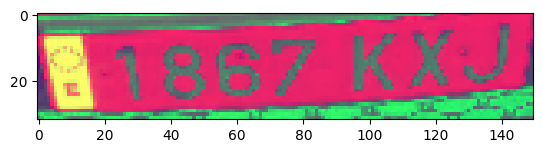

In [34]:
# Convertir imagen a espacio HSV
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Show image
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB))
plt.show()

## 3. Binarize using Otsu

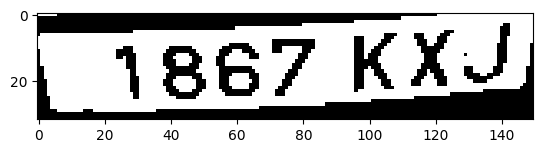

In [38]:
# Obtener el canal de valor (V) del HSV
v_channel = hsv[:,:,2]

# Binarizar la imagen usando el método de Otsu
_, binary_image = cv2.threshold(v_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Erosionar para eliminar ruido
# kernel = np.ones((2,2), np.uint8)
# binary_image = cv2.erode(binary_image, kernel, iterations=1)

# Mostrar la imagen binarizada
plt.imshow(binary_image, cmap='gray')




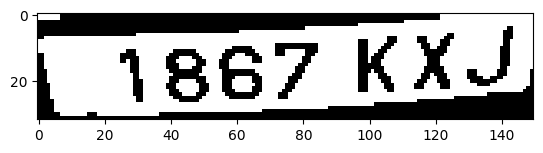

In [37]:
bin_cp = binary_image.copy()
kernel = np.ones((2,2), np.uint8)
bin_d = cv2.dilate(bin_cp, kernel, iterations=1)
bin_e = cv2.erode(bin_d, kernel, iterations=1)

plt.imshow(bin_e, cmap='gray')

## 4. Find contours

In [26]:
## fun aux

def is_inside(contour1, contour2):
    """ Verifica si contour1 está completamente dentro de contour2 """
    x1, y1, w1, h1 = cv2.boundingRect(contour1)
    x2, y2, w2, h2 = cv2.boundingRect(contour2)
    
    return (x1 > x2 and y1 > y2 and (x1 + w1) < (x2 + w2) and (y1 + h1) < (y2 + h2))


In [44]:
## aux fun
def find_contours_mat(binary_image,image = None):
    # Encontrar contornos en la imagen binarizada
    contours_letters, _ = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Limites Width y Height
    w_min = 5
    w_max = 30
    h_min = 15
    h_max = 40

    if image is not None:
        image_cp2 = image.copy()

    filt_contours = []
    # Dibujar un rectángulo sobre cada contorno
    for contour in contours_letters:
        # # Obtener las coordenadas del rectángulo que encierra el contorno
        x, y, w, h = cv2.boundingRect(contour)
        print(x,y,w,h)
        cv2.rectangle(image_cp2, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde, grosor 2
        plt.imshow(cv2.cvtColor(image_cp2, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Opcional: para ocultar los ejes
        plt.show()
        if w_min < w < w_max and h_min < h < h_max:
            # Filtrar contornos que tocan los bordes (posición en los 0)
            if x > 0 and y > 0 and (x + w) < binary_image.shape[1] and (y + h) < binary_image.shape[0]:
                filt_contours.append(contour)

    # Crear una lista de contornos a eliminar
    contours_to_remove = []

    # # Eliminar contornos sobre otros contornos
    # for i,cnt in enumerate(filt_contours):
    #     for j,cnt2 in enumerate(filt_contours):
    #         b = is_inside(cnt, cnt2)
    #         x1, y1, w1, h1 = cv2.boundingRect(cnt)
    #         x2, y2, w2, h2 = cv2.boundingRect(cnt2)
    #         if i!=j:
    #             if x1==x2 and y1 == y2 and w1 == w2 and h1 == h2:
    #                 print('cnt1:',i,x1,y1,w1,h1)
    #                 print('cnt2:',j,x2,y2,w2,h2)
    #                 contours_to_remove.append(cnt)
    #         if b:
    #             print('cnt1:',x1,y1,w1,h1)
    #             print('cnt2:',x2,y2,w2,h2)
    #             contours_to_remove.append(cnt)

    # # Eliminar los contornos marcados, usando boundingRect para comparar los contornos
    # filt_contours = [cnt for cnt in filt_contours if cv2.boundingRect(cnt) not in [cv2.boundingRect(c) for c in contours_to_remove]]

    # # eliminar contornos sobrepuestos y duplicados
    # for i, cnt in enumerate(filt_contours):
    #     for j, cnt2 in enumerate(filt_contours):
    #         if i != j:
    #             b = is_inside(cnt, cnt2)
    #             x1, y1, w1, h1 = cv2.boundingRect(cnt)
    #             x2, y2, w2, h2 = cv2.boundingRect(cnt2)
    #             if x1==x2 and y1 == y2 and w1 == w2 and h1 == h2 or b:
    #                 filt_contours.remove(cnt)

    # Crear una lista de contornos a eliminar
    contours_to_remove = set()

    # Eliminar contornos sobrepuestos y duplicados
    for i, cnt in enumerate(filt_contours):
        # Si el índice de cnt ya está marcado para eliminar, se salta
        if i in contours_to_remove:
            continue
        
        for j, cnt2 in enumerate(filt_contours):
            if i != j:
                # Si el índice de cnt2 ya está marcado para eliminar, se salta
                if j in contours_to_remove:
                    continue
                
                b = is_inside(cnt, cnt2)
                x1, y1, w1, h1 = cv2.boundingRect(cnt)
                x2, y2, w2, h2 = cv2.boundingRect(cnt2)

                # Verificar si son iguales o si uno está dentro del otro
                if (x1 == x2 and y1 == y2 and w1 == w2 and h1 == h2) or b:
                    contours_to_remove.add(i)  # Añadir índice de cnt a eliminar
                    break  # No es necesario seguir iterando sobre cnt2

    # Filtrar contornos que no están en contours_to_remove
    filt_contours = [cnt for i, cnt in enumerate(filt_contours) if i not in contours_to_remove]

                

    return filt_contours

23 14
23 15
23 14
22 15
22 15


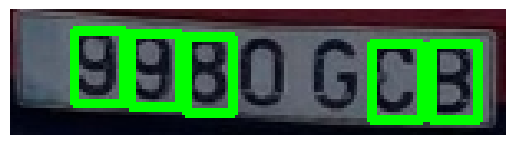

In [248]:
# image_cp3 = image.copy()
# filt_cnt_tmp = find_contours_mat(bin_e, image=image)


# # Dibujar un rectángulo sobre cada contorno
# for contour in filt_cnt_tmp:
#     # Obtener las coordenadas del rectángulo que encierra el contorno
#     x, y, w, h = cv2.boundingRect(contour)
#     # Dibujar el rectángulo en la imagen
#     cv2.rectangle(image_cp3, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde, grosor 2
#     print(h, w)

# # Mostrar la imagen con los contornos filtrados
# plt.imshow(cv2.cvtColor(image_cp3, cv2.COLOR_BGR2RGB))
# plt.axis('off')  # Opcional: para ocultar los ejes
# plt.show()

Intent 1
41 19 7 5


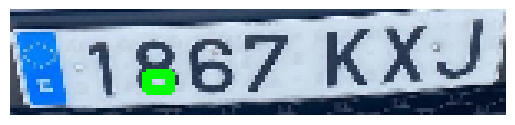

58 18 7 5


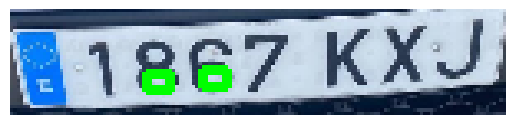

41 12 6 4


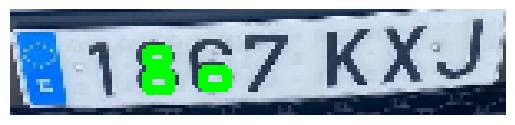

0 0 150 30


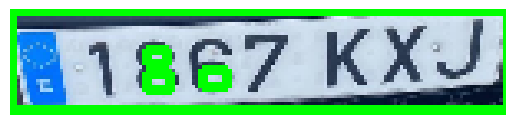

128 11 3 3


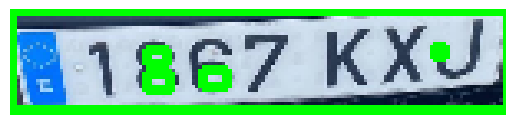

37 9 15 18


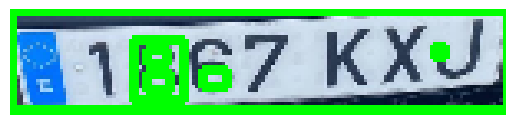

23 9 9 18


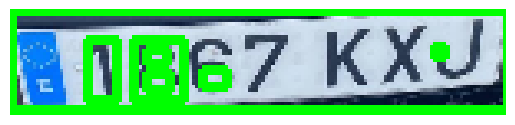

53 8 15 18


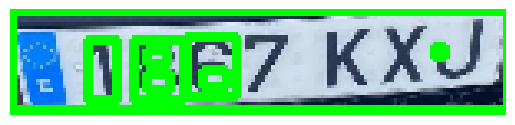

70 7 15 19


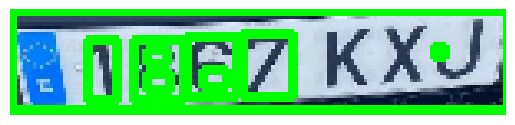

95 5 15 20


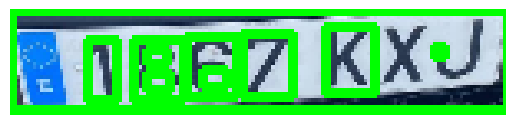

112 4 15 19


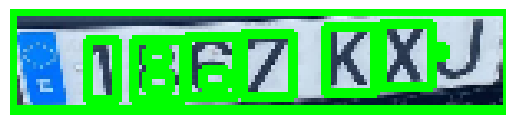

128 2 16 20


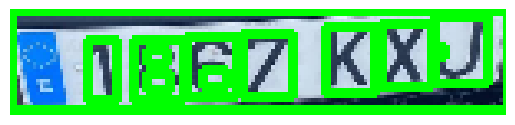

0 0 6 1


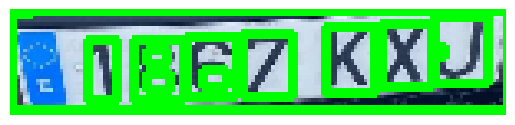

37 9 15 18


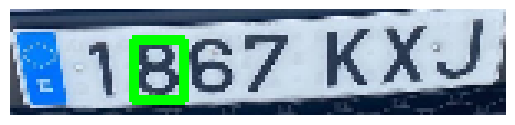

23 9 9 18


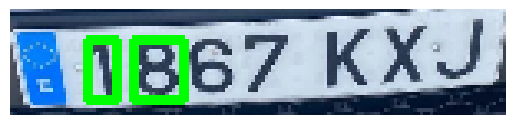

53 8 15 18


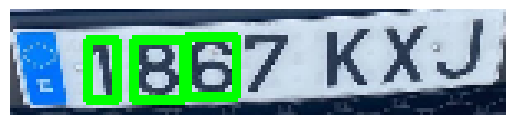

70 7 15 19


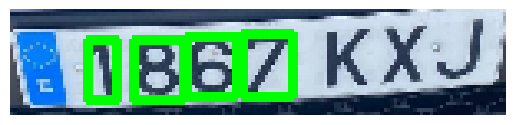

95 5 15 20


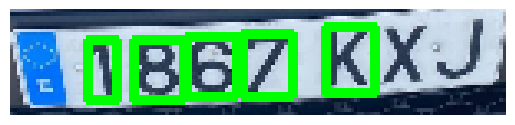

112 4 15 19


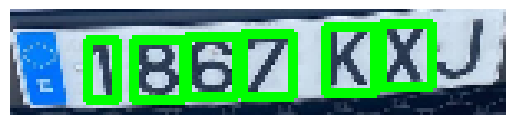

128 2 16 20


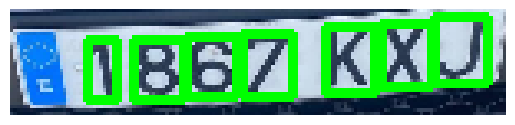

l 7


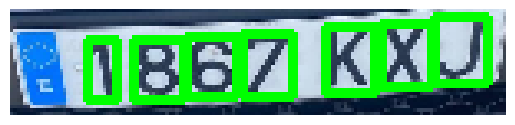

In [45]:
# Copiamos la imagen original para no modificarla
image_cp = image.copy()
image_cp2 = image.copy()



n_intents = 3
for i in range(n_intents):
    
    # 1. Si 1r intent, fem find_contours_mat normal
    if i == 0:
        print('Intent 1')
        flt_contours = find_contours_mat(binary_image,image)

        # print('l', len(flt_contours))
        # try1_img = image_cp2.copy()
        # # draw borders of the contours
        # for contour in flt_contours:
        #     x, y, w, h = cv2.boundingRect(contour)
        #     cv2.rectangle(try1_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # 2. Si es el 2n intent, fem dilate + erode
    if i == 1:
        bin_cp = binary_image.copy()
        print('Intent 2')
        kernel = np.ones((2, 2), np.uint8)
        bin_cp = cv2.dilate(bin_cp, kernel, iterations=1)
        bin_cp = cv2.erode(bin_cp, kernel, iterations=1)

        flt_contours = find_contours_mat(bin_cp, image)

        print('l', len(flt_contours))

    # 3. Si es el 3r intent, fem canny edge
    if i == 2:
        bin_cp = binary_image.copy()
        print('Intent 3')
        # Convertir imagen a escala de grises
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Aplicar un filtro de mediana para eliminar ruido
        gray = cv2.medianBlur(bin_cp, 3)

        # Aplicar el detector de bordes Canny
        edges = cv2.Canny(gray, 50, 150)

        # Encontrar contornos en la imagen binarizada
        flt_contours = find_contours_mat(edges, image)
        

    if len(flt_contours) == 7:
        break

# Dibujar un rectángulo sobre cada contorno
for contour in flt_contours:
    # Obtener las coordenadas del rectángulo que encierra el contorno
    x, y, w, h = cv2.boundingRect(contour)
    print(x, y, w, h)
    # Dibujar el rectángulo en la imagen
    cv2.rectangle(image_cp, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Verde, grosor 2

    # Mostrar la imagen con los contornos filtrados
    plt.imshow(cv2.cvtColor(image_cp, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Opcional: para ocultar los ejes
    plt.show()


print('l', len(flt_contours))

# Mostrar la imagen con los contornos filtrados
plt.imshow(cv2.cvtColor(image_cp, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Opcional: para ocultar los ejes
plt.show()


29 7


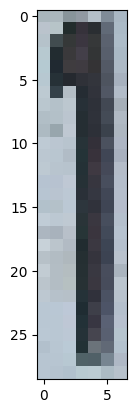

In [89]:
crp_dig = image[y:y + h, x:x + w]

plt.imshow(crp_dig)

# img size
h, w, _ = crp_dig.shape
print(h, w)



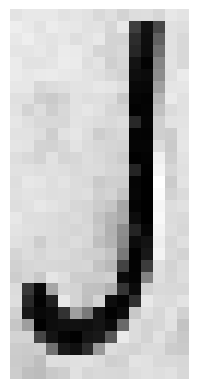

In [71]:
# Aumentar el contraste en una imagen en escala de grises usando cv2.normalize()
normalized_image = cv2.normalize(crp_dig, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

# pasar a escalas de grises
normalized_image = cv2.cvtColor(normalized_image, cv2.COLOR_BGR2GRAY)

# Mostrar la imagen con mayor contraste
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.show()

## FUNCION COMPLETA

hem afegit que els contours s'afegeixin ordenats per la coordenada x, de esquerra a dreta.

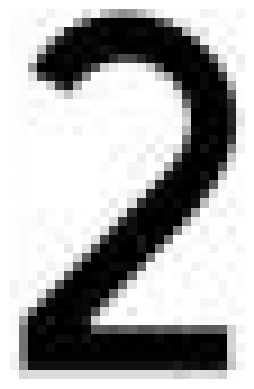

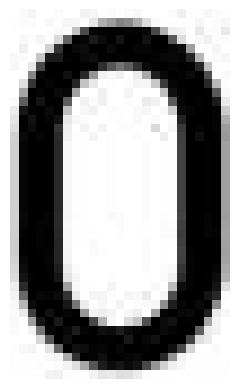

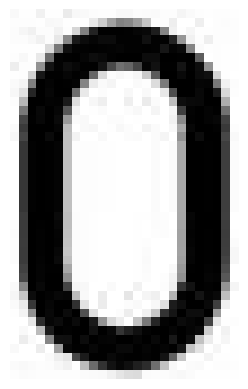

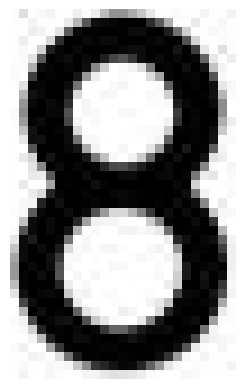

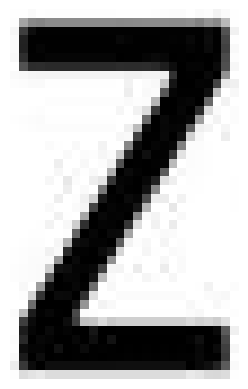

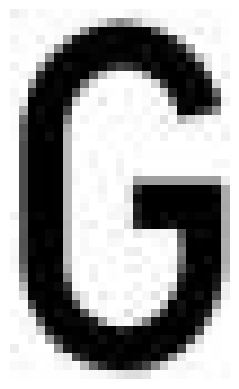

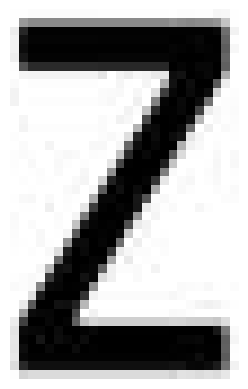

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def recortar_numeros_matricula(image_path):
    # Cargar imagen desde el path
    image = cv2.imread(image_path)

    # Convertir imagen a espacio HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Obtener el canal de valor (V) del HSV
    v_channel = hsv[:, :, 2]

    # Binarizar la imagen usando el método de Otsu
    _, binary_image = cv2.threshold(v_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Copiamos la imagen original para no modificarla
    image_cp = image.copy()

    # Pasar image_cp a escala de grises L
    image_cp = cv2.cvtColor(image_cp, cv2.COLOR_BGR2GRAY)

    # Encontrar contornos en la imagen binarizada
    contours_letters, _ = cv2.findContours(binary_image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Ordenar los contornos de izquierda a derecha
    contours_letters = sorted(contours_letters, key=lambda contour: cv2.boundingRect(contour)[0])

    # Establecer umbrales para el área de los contornos
    area_min = 400
    area_max = 900

    # Lista para almacenar los recortes de los números/letras
    digits_matricula = []

    # Dibujar un rectángulo sobre cada contorno y guardar los recortes
    for contour in contours_letters:
        # Obtener las coordenadas del rectángulo que encierra el contorno
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)

        # Filtrar por área (demasiado pequeño o demasiado grande)
        if area_min < area < area_max:
            # Filtrar contornos que tocan los bordes (posición en los 0)
            if x > 0 and y > 0 and (x + w) < image_cp.shape[1] and (y + h) < image_cp.shape[0]:
                # Recortar el contorno (número o letra)
                digit = image_cp[y:y + h, x:x + w]
                digits_matricula.append(digit)

    return digits_matricula

# Ejemplo de uso:
digits_matricula = recortar_numeros_matricula('img_exemple\exemple_matricula_es.jpeg')

# Mostrar cada recorte
for i, d in enumerate(digits_matricula):
    plt.imshow(cv2.cvtColor(d, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Opcional para ocultar los ejes
    plt.show()

# Guardar los recortes en digits_proves
for i, d in enumerate(digits_matricula):
    cv2.imwrite(f'digits_proves/digit_{i}.png', d)


## REDIMENSIONAR Y UNIFICAR TAMANY

In [6]:
from PIL import Image
import os

def redimensionar_con_relleno(imagen, tamaño=(40, 64)):
    """Redimensiona la imagen a un tamaño específico con relleno."""
    # Calcular la relación de aspecto de la imagen original
    ancho_original, alto_original = imagen.size
    relacion_aspecto_original = ancho_original / alto_original
    
    # Calcular el tamaño nuevo manteniendo la relación de aspecto
    if relacion_aspecto_original > (tamaño[0] / tamaño[1]):  # Imagen más ancha que el tamaño deseado
        nuevo_ancho = tamaño[0]
        nuevo_alto = int(nuevo_ancho / relacion_aspecto_original)
    else:  # Imagen más alta que el tamaño deseado
        nuevo_alto = tamaño[1]
        nuevo_ancho = int(nuevo_alto * relacion_aspecto_original)
    
    # Redimensionar la imagen
    imagen_redimensionada = imagen.resize((nuevo_ancho, nuevo_alto), Image.LANCZOS)

    # Crear una nueva imagen en blanco (relleno)
    imagen_final = Image.new('L', tamaño, color=255)  # Fondo blanco
    # Calcular la posición para centrar la imagen redimensionada
    posicion = ((tamaño[0] - nuevo_ancho) // 2, (tamaño[1] - nuevo_alto) // 2)
    # Pegar la imagen redimensionada en la nueva imagen
    imagen_final.paste(imagen_redimensionada, posicion)
    
    return imagen_final

def guardar_imagenes_recortadas_y_redimensionadas(carpeta_entrada, carpeta_salida):
    """Recorta y redimensiona imágenes en una carpeta."""
    if not os.path.exists(carpeta_salida):
        os.makedirs(carpeta_salida)
        
    for archivo in os.listdir(carpeta_entrada):
        if archivo.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
            # Cargar la imagen
            ruta_imagen = os.path.join(carpeta_entrada, archivo)
            imagen = Image.open(ruta_imagen)

            # Redimensionar la imagen con relleno
            imagen_redimensionada = redimensionar_con_relleno(imagen, tamaño=(40, 64))
            
            # Guardar la imagen redimensionada
            imagen_redimensionada.save(os.path.join(carpeta_salida, archivo))

# Uso
carpeta_entrada = 'digits_proves'  # Ajusta esta ruta
carpeta_salida = 'digits_proves_retallades'  # Ajusta esta ruta
guardar_imagenes_recortadas_y_redimensionadas(carpeta_entrada, carpeta_salida)


In [7]:
# show sizes digits_proves_retallades
for archivo in os.listdir(carpeta_salida):
    if archivo.endswith(('.png', '.jpg', '.jpeg')):  # Filtrar imágenes
        # Cargar la imagen
        ruta_imagen = os.path.join(carpeta_salida, archivo)
        imagen = Image.open(ruta_imagen)
        print(imagen.size)

(40, 64)
(40, 64)
(40, 64)
(40, 64)
(40, 64)
(40, 64)
(40, 64)
